In [1]:
import dbcollection as dbc
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
data = pd.read_csv('../data/kaggle_mpii/mpii_human_pose.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17372 entries, 0 to 17371
Data columns (total 37 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            17372 non-null  int64  
 1   NAME          17372 non-null  object 
 2   r ankle_X     17372 non-null  int64  
 3   r ankle_Y     17372 non-null  int64  
 4   r knee_X      17372 non-null  int64  
 5   r knee_Y      17372 non-null  int64  
 6   r hip_X       17372 non-null  int64  
 7   r hip_Y       17372 non-null  int64  
 8   l hip_X       17372 non-null  int64  
 9   l hip_Y       17372 non-null  int64  
 10  l knee_X      17372 non-null  int64  
 11  l knee_Y      17372 non-null  int64  
 12  l ankle_X     17372 non-null  int64  
 13  l ankle_Y     17372 non-null  int64  
 14  pelvis_X      17372 non-null  int64  
 15  pelvis_Y      17372 non-null  int64  
 16  thorax_X      17372 non-null  int64  
 17  thorax_Y      17372 non-null  int64  
 18  upper neck_X  17372 non-nu

In [4]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        #plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('Число')
        #plt.xticks(rotation = 90)
        plt.title('Категории набора данных MPII Human Pose')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.savefig('../imgs/mpii_cats.png')
    plt.show()

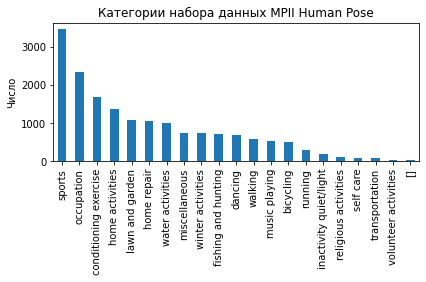

In [5]:
plotPerColumnDistribution(data, 10, 5)

In [6]:
len(data.loc[(data['Activity'].str.contains('sleeping'))])

12

In [7]:
cats = set(list(data['Category']))
print(cats)

{'occupation', 'self care', 'religious activities', 'home activities', 'water activities', 'miscellaneous', 'fishing and hunting', 'music playing', 'winter activities', 'inactivity quiet/light', 'running', 'transportation', 'dancing', 'home repair', 'sports', '[]', 'conditioning exercise', 'bicycling', 'lawn and garden', 'walking', 'volunteer activities'}


In [8]:
with open('../data/mpii_anns/mpii_trainval.json') as f:
    mpii_data = json.load(f)

In [9]:
len(mpii_data)

29116

In [10]:
my_mpii = []

In [11]:
good_cats = ['running', 'dancing', 'bicycling', 'walking', 'fishing and hunting']

In [12]:
good_acts = ['standing', 'sitting', 'skiing', 'swimming', 'cooking', 
             'driving', 'rock climbing', 'horseback', 'skateboarding',
             'yoga', 'canoe', 'training', 'lying']

In [13]:
len(good_cats) + len(good_acts) + 1

19

In [14]:
for i in mpii_data:
    name = i['image']
    cat = data.loc[data['NAME'] == name]['Category'].values
    act = data.loc[data['NAME'] == name]['Activity'].values
    if len(cat) > 0:
        if (cat[0] in good_cats):
            i['category'] = cat[0]
            my_mpii.append(i)
        elif (cat[0] == 'sports' and bool(re.search('\wball', act[0]))):
            i['category'] = 'ball'
            my_mpii.append(i)
        else:
            for good_act in good_acts:
                if good_act in act[0]:
                    i['category'] = good_act
                    my_mpii.append(i)

In [15]:
with open('../data/mpii_all.json', 'w') as f:
    json.dump(my_mpii, f)

In [22]:
cats = ['running', 'dancing', 'bicycling', 'walking', 'fishing and hunting', 'ball',
        'standing', 'sitting', 'skiing', 'swimming', 'cooking', 'driving', 'rock climbing', 
        'horseback', 'skateboarding', 'yoga', 'canoe', 'training', 'lying']

In [27]:
for big_cat in cats:
    one_cat_mpii = []
    for i in mpii_data:
        name = i['image']
        cat = data.loc[data['NAME'] == name]['Category'].values
        act = data.loc[data['NAME'] == name]['Activity'].values
        if len(cat) > 0:
            if (cat[0] in big_cat) or (cat[0] == 'sports' and bool(re.search('\wball', act[0])) and big_cat == 'ball') or (big_cat in act[0]):
                i['category'] = big_cat
                one_cat_mpii.append(i)
    print(big_cat + ':', len(one_cat_mpii))
    with open('../data/mpii_' + big_cat + '.json', 'w') as f:
        json.dump(one_cat_mpii, f)

running: 615
dancing: 2299
bicycling: 1015
walking: 1572
fishing and hunting: 896
ball: 3251
standing: 2314
sitting: 1482
skiing: 586
swimming: 367
cooking: 329
driving: 168
rock climbing: 175
horseback: 202
skateboarding: 251
yoga: 487
canoe: 436
training: 421
lying: 38


In [ ]:
df = pd.read_json('../data/mpii.json')

In [ ]:
plot = df['category'].value_counts().plot(kind='bar');
plot.set_ylabel('Число')
plot.set_title('Категории')

In [ ]:
j = df[df['category'] == 'sitting'].iloc[[2]]['joints'].values

In [ ]:
fig = plot.get_figure()

fig.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
fig.savefig('../imgs/my_cats.png')